In [30]:
import pandas as pd
import re
import bz2
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import FeatureAgglomeration
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean, cityblock

In [3]:
bills = pd.read_csv('../data_cleaning/bills.csv').drop(columns='Unnamed: 0')

### Vectorization and IDF scaling

In [21]:
tfidf = TfidfVectorizer(token_pattern=r'[a-z]+', stop_words='english', min_df=0.01, max_df=0.99).fit(bills['long_title'])
X_idf  = tfidf.transform(bills['long_title']).toarray()
X_feat_names = tfidf.get_feature_names()

In [5]:
# svd = TruncatedSVD(n_components=long_title_tfidf.shape[1]-1).fit(long_title_tfidf)
# X_reduced = svd.transform(long_title_tfidf)
# var_ex = svd.explained_variance_

In [19]:
# p = 0.0001
# sel = VarianceThreshold(threshold=(p*(1-p))).fit(X)
# X_reduced = sel.transform(X)

In [22]:
def truncated_svd(X):
    '''Reduce dimensionality of TFIDF Matrix.'''
    q, s, p = np.linalg.svd(X)
    return q, np.diag(s), p.T, s**2/np.linalg.norm(s**2, 1)

q, s, p, nssd = truncated_svd(X_idf)

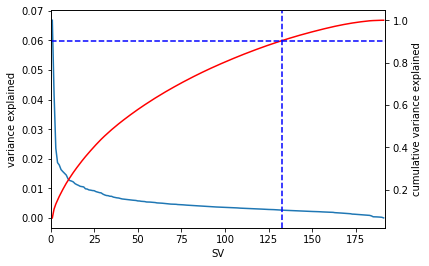

In [26]:
fig, ax = plt.subplots()

ax.plot(range(1, len(nssd)+1), nssd, '-', label='individual')
ax.set_xlim(0, len(nssd)+1)
ax.set_xlabel('SV')
ax.set_ylabel('variance explained')
ax = ax.twinx()
ax.plot(range(1, len(nssd)+1), nssd.cumsum(), 'r-', label='cumulative')
ax.axhline(0.9, ls='--', color='b')
ax.axvline(133, ls='--', color='b')
ax.set_ylabel('cumulative variance explained');

In [32]:
X_trunc = X.dot(p[:, :133])

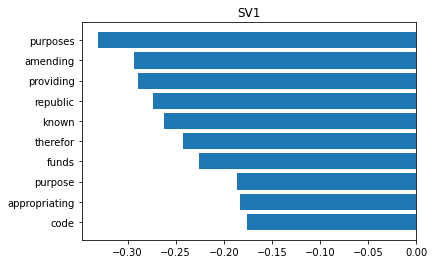

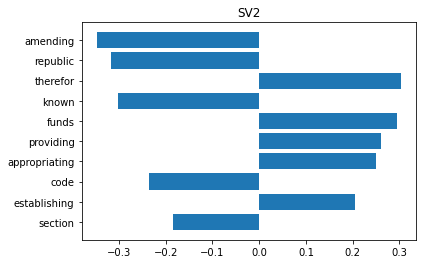

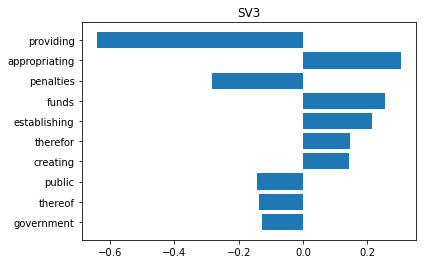

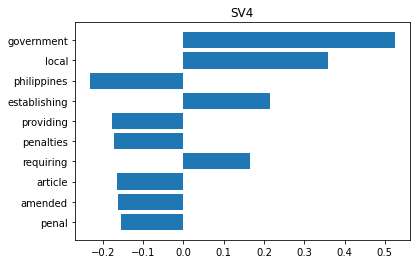

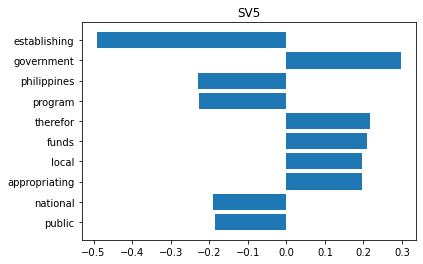

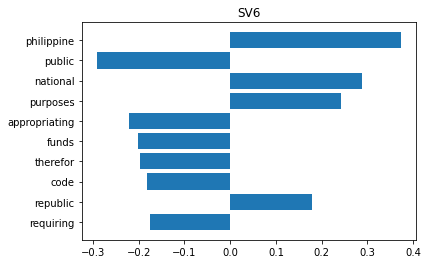

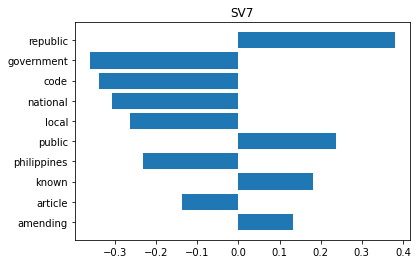

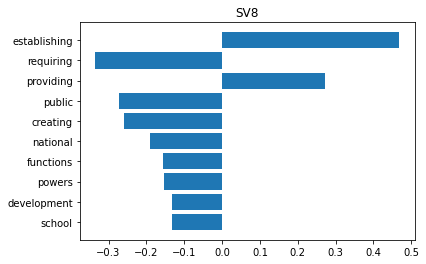

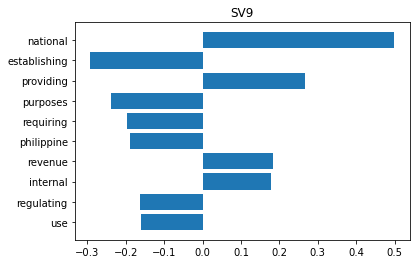

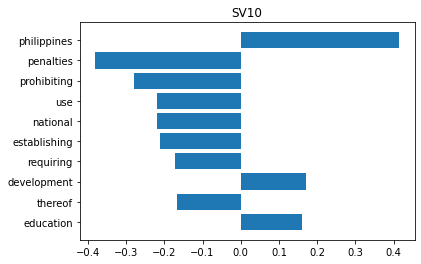

In [28]:
for i in range(10):
    fig, ax = plt.subplots()
    order = np.argsort(np.abs(p[:, i]))[-10:]
    ax.barh([X_feat_names[o] for o in order], p[order, i])
    ax.set_title(f'SV{i+1}')

In [34]:
def pooled_within_ssd(X, y, centroids, dist):
    """Compute pooled within-cluster sum of squares around the cluster mean
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
        
    Returns
    -------
    float
        Pooled within-cluster sum of squares around the cluster mean
    """
    Q_j = np.zeros(len(np.unique(y)))
    for index, cluster_i in enumerate(y):
        Qj_col = {v: k for k, v in enumerate(np.unique(y))}
        Q_j[Qj_col[cluster_i]] += dist(X[index, :], centroids[cluster_i, :])**2
    return sum(0.5*Q_j/np.unique(y, return_counts=True)[1])

def gap_statistic(X, y, centroids, dist, b, clusterer, random_state=None):
    """Compute the gap statistic
    
    Parameters
    ----------
    X : array
        Design matrix with each row corresponding to a point
    y : array
        Class label of each point
    centroids : array
        Number of pairs to sample
    dist : callable
        Distance between two points. It should accept two arrays, each 
        corresponding to the coordinates of each point
    b : int
        Number of realizations for the reference distribution
    clusterer : KMeans
        Clusterer object that will be used for clustering the reference 
        realizations
    random_state : int, default=None
        Determines random number generation for realizations
        
    Returns
    -------
    gs : float
        Gap statistic
    gs_std : float
        Standard deviation of gap statistic
    """
    rng = np.random.default_rng(random_state)
    W_ki = []
    for i in range(b):
        distribution = rng.uniform(X.min(0), X.max(0), X.shape)
        realizations = clusterer.fit_predict(distribution)
        W_ki.append(np.log(pooled_within_ssd(distribution, realizations, 
                                             clusterer.cluster_centers_, 
                                             dist)))
    E_logWk = np.mean(W_ki)
    Gap = E_logWk - np.log(pooled_within_ssd(X, y, centroids, dist))
    return Gap, np.std(W_ki)

inertia = []
CH = []
SC= []
GS = []
y_pred_list = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, max_iter=300, tol=1e-4, n_jobs=-1).fit(X_trunc)
    y_pred = km.predict(X_trunc)
    y_pred_list.append(y_pred)
    inertia.append(km.inertia_)
    CH.append(calinski_harabasz_score(X_trunc, y_pred))
    SC.append(silhouette_score(X_trunc, y_pred))
    GS.append(gap_statistic(X_trunc, y_pred, km.cluster_centers_, euclidean,
                            len(np.unique(y_pred)), KMeans(n_clusters=k),
                            random_state=42)[0])

In [35]:
## Plot the clusters

X_trunc2 = (TruncatedSVD(n_components=2)
                    .fit_transform(X))

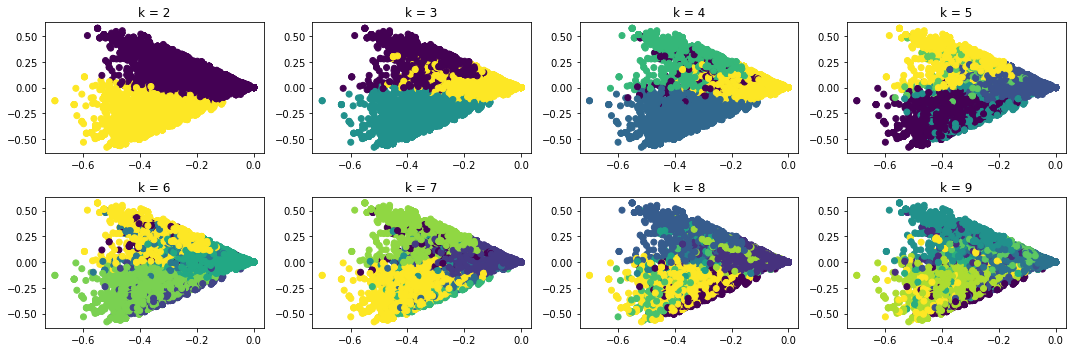

In [44]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(15, 5))
ax_list = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i in range(2, 10):
    ax_list[i-2].scatter(X_trunc[:, 0], X_trunc[:, 1], c=y_pred_list[i-2])
    ax_list[i-2].set_title(f'k = {i}')
    
plt.tight_layout()